In [1]:
%matplotlib inline
from __future__ import division
from __future__ import print_function
import re
import random
import json
import artm
import collections
import matplotlib.pyplot as plt
import matplotlib
import datetime
import numpy as np
import sklearn.decomposition
import requests
from pymystem3 import Mystem
import lxml.html
import urllib
import time

C:\ProgramData\Anaconda2\lib\site-packages\_pytest\mark\structures.py:383: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [2]:
lemmatizer = Mystem()
days_pattern = "[1-9][0-9]?_((января)|(февраля)|(марта)|(апреля)|(мая)|(июня)|(июля)|(августа)|(сентября)|(октября)|(ноября)|(декабря))"
matplotlib.rcParams['figure.figsize'] = [18, 18]

topics_count = 15
num_top_tokens = 28
doc_passes = 10
total_passes = 250
pass_batch = 10

sparsity_theta_tau = 0.2
sparsity_phi_tau = 1e-10
decorrelator_tau = 12.26
sparsity_threshild = 1e-3
kernel_threshold = 0.3


perplexity_score_name = "Perplexity"

In [3]:
def load_str(s):
    try:
        return str(s)
    except:
        return str(unicode(s).encode("utf8"))

def dumps(o):
    return json.dumps(o,indent=2,ensure_ascii=False, sort_keys=True, default=load_str)

def get_data_from_wikipedia_page(page_name, paragraph=None):
    response = requests.get("https://ru.wikipedia.org/wiki/{}".format(load_str(page_name)))
    html_tree = lxml.html.fromstring(response.content)
    all_text_nodes = html_tree.findall(".//div[@id='content'][@class='mw-body'][@role='main']//p")
    if paragraph is not None:
        assert paragraph>0
        all_text_nodes=all_text_nodes[:paragraph]
    text = "\n\n".join(node.text_content() for node in all_text_nodes)
    anchors  = html_tree.findall(".//a[@href][@title]")
    anchors = [load_str(urllib.unquote(node.attrib["href"][len("/wiki/"):]))
               for node in anchors
               if node.attrib["href"].startswith("/wiki/")]
    anchors = [unicode(load_str(name).decode("utf8"))
               for name in anchors
               if ((":" not in name)
                    and 
                   ("#" not in name)
                   and 
                   (name not in {"Заглавная_страница",page_name})
                   and
                   (not name.endswith("_век"))
                   and
                   (not name.endswith("_год"))
                   and
                   (not name.endswith("_династия"))
                   and
                   (not name.startswith("Список_"))
                   and
                   (re.match(days_pattern, name) is None)
                   and
                   (not name.isalnum()))]
    return {
        "text": text,
        "anchors":anchors
    }

def create_corpus(themes, depth=1, limit=10, paragraph=None):
    doc_name_to_doc_content = {}
    doc_name_to_doc_themes = {}
    doc_name_to_anchors = {}
    t_count = 0
    for t in themes:
        t_count +=1
        print("{}. {}".format(t_count,t))
        d_count =0
        stack = [(t,0)]
        while len(stack)>0:
            n,d = stack.pop(0)
            if d>depth:
                continue
            if n in themes and d !=0:
                continue
            d_count+=1
            doc_name_to_doc_themes.setdefault(n,set()).add(t)
            if n in doc_name_to_doc_content:
                new_pages = doc_name_to_anchors[n]
            else:
                data = get_data_from_wikipedia_page(n, paragraph=paragraph)
                doc_text = data["text"]
                new_pages = collections.Counter(data["anchors"]).keys()
                doc_name_to_doc_content[n] = doc_text
                random.shuffle(new_pages)
                doc_name_to_anchors[n] = new_pages
            print("    {}. {} ({} ссылок)".format(d_count, n,len(new_pages)))
            for new_name in new_pages:
                doc_name_to_doc_themes.setdefault(new_name,set()).add(t)
            for new_name in new_pages[:limit]:
                stack.insert(0,(load_str(new_name),d+1))
    result =[]
    for name, doc_text in doc_name_to_doc_content.items():
        themes_set = doc_name_to_doc_themes[name]
        if len(themes_set)==1:
            doc_theme = themes_set.pop()
        elif name in themes:
            doc_theme = name
        else:
            continue
        result.append({
            "name": load_str(name),
            "text": load_str(doc_text),
            "theme": load_str(doc_theme)
        })
    print("Размер корпуса: ",len(result), "документов")
    return result 

def plot_scores(scores_dict, models_dict):
    assert len(scores_dict)==3
    model_name_to_score_label_to_last_value = {}
    for model_name, model_obj in models_dict.items():
        last_kernel_contrast = model_obj.score_tracker["TopicKernel"].last_average_contrast
        last_kernel_purity = model_obj.score_tracker["TopicKernel"].last_average_purity
        model_name_to_score_label_to_last_value.setdefault(model_name,{}).setdefault("AVG topic kernel contrast",last_kernel_contrast)
        model_name_to_score_label_to_last_value.setdefault(model_name,{}).setdefault("AVG topic kernel purity",last_kernel_purity)
        for score_key, score_build_data in scores_dict.items():
            score_label = score_build_data["label"]
            score_value = model_obj.score_tracker[score_key].last_value
            model_name_to_score_label_to_last_value.setdefault(model_name,{}).setdefault(score_label,score_value)
    score_label_to_model_name_to_line = {}
    for model_name, model_obj in models_dict.items():
        model_N = model_obj.num_phi_updates
        model_x_vec = range(model_N)
        score_label_to_model_name_to_line.setdefault("AVG topic kernel contrast", {}).setdefault(
            model_name,
            (model_x_vec,
             model_obj.score_tracker["TopicKernel"].average_contrast)
        )
        score_label_to_model_name_to_line.setdefault("AVG topic kernel purity", {}).setdefault(
            model_name,
            (model_x_vec,
             model_obj.score_tracker["TopicKernel"].average_purity)
        )
    
    for score_key, score_build_data in scores_dict.items():
        score_label = score_build_data["label"]
        for model_name, model_obj in models_dict.items():
            model_N = model_obj.num_phi_updates
            model_x_vec = range(model_N)
            model_y_vec = model_obj.score_tracker[score_key].value
            assert len(model_x_vec) == len(model_y_vec)
            score_label_to_model_name_to_line.setdefault(score_label,{}).setdefault(model_name,(model_x_vec,model_y_vec))
    name_to_pos = {
        "sparsity $\\Phi$": 321,
        "sparsity $\\Theta$": 322,
        "perplexity": 313,
        "AVG topic kernel contrast": 323,
        "AVG topic kernel purity": 324
    }
    for name, pos in name_to_pos.items():
        plt.subplot(pos)
        plt.title(name)
        for model_name, (x,y) in score_label_to_model_name_to_line[name].items():
            label = "{}. Final Value: {:.4g}".format(model_name,model_name_to_score_label_to_last_value[model_name][name])
            plt.plot(x,y,linestyle="--", label=label)
        plt.grid()
        plt.xlabel("Iterations")
        plt.ylabel("Value")
        plt.legend()
    plt.show()


def print_top_words(model_name, model_obj):
    print("Topics top tokens for {} model:".format(model_name))
    for topic_name in model_obj.topic_names:
        header =  "    {}: ".format(topic_name)
        print(header,end="")
        line_splitter = ",\n"+(" " * len(header))
        tok_splitter = ", "
        tokens=["<{}>".format(word) for word in model_obj.score_tracker["TopTokensScore"].last_tokens[topic_name]]
        table = [[]]
        for token in tokens:
            if len(table[-1])>=7:
                table.append([])
            table[-1].append(token)
        print(line_splitter.join(tok_splitter.join(line) for line in table ))

def plot_topics(model_name, model_obj, markersize=50):
    phi_matrix,words, topics =model_obj.get_phi_dense()
    theta_matrix = model_obj.get_theta().values.T
    data_for_pca = (np.vstack((phi_matrix,theta_matrix))).T
    pca_1_2 = sklearn.decomposition.PCA(n_components=2).fit_transform(data_for_pca)
    x = pca_1_2[:,0]
    y = pca_1_2[:,1]
    plt.plot(x,y,"or", markersize=markersize)
    assert len(x) == len(topics) == len(y)
    for _x,_y,_t in zip(x,y,topics):
        plt.text(_x,_y,_t)
    plt.grid()
    plt.title("Topics of model {} in PCA1-PCA2 of words-documents space".format(model_name))
    plt.show()    

# Тематическое моделирование

## Установка пакетов 
### BigARTM
Знатно потупил. Сумел поставить версию 0.9.0 (не последнюю 0.10.0), но и тут возникло несколько трудностей. Основная проблема: библиотека не распостраняется ни через pypi ни через default anaconda channels, да и вообще не посредством каналов. 
### Лематизатор для русского языка pymystem3
Лематизатор распостраняется через pypi а значит он устанавливается простым (inline) `pip install pymystem3` (3 это версия библиотеки -- не питона). Настроить канал для анаконды, чтобы поставить эту библиотеку при помощи (inline) `conda install pymystem3` тоже можно. Библиотека доступма как для второго питона так и для третьего.

## Предварительная обработка текста
* Лемматизация -- приведение каждого слова в тексте к его нормальной форме. Хорошими лематизаторами для русскоязычных текстов являются mystem pymorphy. Тут буду использоваться mystem.
* Стемминг -- удаление окончаний. Такая "недолематизация". Подходит для английского языка, не подходит для русского
* Удаление стоп-слов -- удаление частых слов, несущественных для определения темы. Это союзы, предлоги, междометья, частицы, некоторые наречия и некоторые числительные. 
* Выделение ключевых фраз и именованных сущностей -- предварительная разметка документов асессорами. Трудоёмки и дорогостоящий процесс, приводящий к увеличению качества. 

Скопируем содержимое этой клетки и попробуем лемматизовать. 

In [4]:
text = """# Тематическое моделирование

## Установка 
### BigARTM
Знатно потупил. Сумел поставить версию 0.9.0 (не последнюю 0.10.0), но и тут возникло несколько трудностей. Основная проблема: библиотека не распостраняется ни через pypi ни через default anaconda channels, да и вообще не посредством каналов. 
### Лематизатор для русского языка pymystem3
Лематизатор распостраняется через pypi а значит он устанавливается простым (inline) `pip install pymystem3` (3 это версия библиотеки -- не питона). Настроить канал для анаконды, чтобы поставить эту библиотеку при помощи (inline) `conda install pymystem3` тоже можно. Библиотека доступма как для второго питона так и для третьего.

## Предварительная обработка текста
* Лемматизация -- приведение каждого слова в тексте к его нормальной форме. Хорошими лематизаторами для русскоязычных текстов являются mystem pymorphy. Тут буду использоваться mystem.
* Стемминг -- удаление окончаний. Такая "недолематизация". Подходит для английского языка, не подходит для русского
* Удаление стоп-слов -- удаление частых слов, несущественных для определения темы. Это союзы, предлоги, междометья, частицы, некоторые наречия и некоторые числительные. 
* Выделение ключевых фраз и именованных сущностей -- предварительная разметка документов асессорами. Трудоёмки и дорогостоящий процесс, приводящий к увеличению качества. 

Скопируем содержимое этой клетки и попробуем лемматизовать. """
analysis = lemmatizer.analyze(text)
stop_parts_of_speech = [
    "CONJ", # Союз
#     "INTJ", # Междометие
    "PART", # Частица
    "PR", # Предлог,
    "ADVPRO", # Местоименное наречие
    "APRO", # Местоимение-прилагательное
    "SPRO", # Местоимение-существительное
    
]
print(dumps(analysis[2]))
real_words = [analysed["text"].lower()
              for analysed in analysis
              if (
                  ("analysis" in analysed) # Признак того, что это слово, состоящее из букв (не обязательно настоящее)
                  and
                  (not any(any(word_data.get("gr","").startswith(p_o_s) for word_data in analysed.get("analysis",[])) for p_o_s in stop_parts_of_speech)) 
                  # Слово не принадлежит к части речи из стоп-списка частей речи (если часть речи была определена, иначе оставлем)
                 )]
lemmas = lemmatizer.lemmatize(" ".join(real_words))
lemmas = [term.strip()
          for term in lemmas
          if len(term.strip())>0]

{
  "analysis": [
    {
      "gr": "A=(вин,ед,полн,сред|им,ед,полн,сред)", 
      "lex": "тематический", 
      "wt": 1
    }
  ], 
  "text": "Тематическое"
}


Так выглядит один токен -- результат работы метода "analyze". Этот метод разбивает текст на токены, и для каждого токена пытается провести семантический анализ. Если токен не является словом в каком-то широком смысле, то поля "analysis" у такого токена не будет, если поле "analysis" есть, но оно пустое, то это скорее всего не русское слово. Как правильно интерпретировать значение в поле можно посмотреть [тут](https://yandex.ru/dev/mystem/doc/grammemes-values-docpage/#grammemes-values__parts). 

Напишем теперь функцию, приводящую весь текст к нормальной форме и откидывающую все ненужные части речи.

In [5]:
def lemmatize_text(input_text):
    analysis = lemmatizer.analyze(input_text)
    stop_parts_of_speech = [
        "CONJ", # Союз
        "PART", # Частица
        "PR", # Предлог,
        "ADVPRO", # Местоименное наречие
        "APRO", # Местоимение-прилагательное
        "SPRO", # Местоимение-существительное
    ]
    real_words = [analysed["text"].lower()
                  for analysed in analysis
                  if (
                      ("analysis" in analysed) # Признак того, что это слово, состоящее из букв (не обязательно настоящее)
                      and
                      (not any(any(word_data.get("gr","").startswith(p_o_s) for word_data in analysed.get("analysis",[])) for p_o_s in stop_parts_of_speech)) 
                      # Слово не принадлежит к части речи из стоп-списка частей речи (если часть речи была определена, иначе оставлем)
                     )]
    lemmas = lemmatizer.lemmatize(" ".join(real_words))
    lemmas = [term.strip()
              for term in lemmas
              if len(term.strip())>0]
    return lemmas

def prepare_bag(input_text):
    return dict(collections.Counter(lemmatize_text(input_text)))

print(" ".join(lemmatize_text(text)))

тематический моделирование установка bigartm знатно потуплять суметь поставлять версия последний возникать несколько трудность основной проблема библиотека распостраняться pypi default anaconda channels вообще канал лематизатор русский язык лематизатор распостраняться pypi значить устанавливаться простой inline pip install версия библиотека питон настраивать канал анаконда поставлять библиотека помощь inline conda install можно библиотека доступма второй питон третий предварительный обработка текст лемматизация приведение слово текст нормальный форма хороший лематизатор русскоязычный текст являться mystem pymorphy быть использоваться mystem стемминг удаление окончание недолематизация подходить английский язык подходить русский удаление стоп слово удаление частый слово несущественный определение тема союз предлог междометие частица наречие числительный выделение ключевой фраза именовать сущность предварительный разметка документ асессор трудоемкий дорогостоящий процесс приводить увеличе

А так выглядит лемматизованный текст. Однако лемматизация долгий процесс, который сильно ограничивает размеры датасета и длину одного текста. Целью кода выше было показать, как работает лемматизация. Само тематическое моделирование будем рассматривать на англоязычных данных.

## Данные
[Источник](https://archive.ics.uci.edu/ml/datasets/Bag+of+Words). В источнике собрано несколько датасетов разных размеров. Мы возьмём самый маленький сет, который поместится в оперативную память и для которого модели будут обучатся адекватное количество времени. Это "KOS blog entries" -- новостные блоги журналистов с сайта "dailykos.com". Данные уже приведены к формату "UCI Bag-of-words" о котором можно почитать на странице данных. Датасет содержит
* 3430 Документов
* Среди всех этих документов втречается 6906 уникаьлных лексем
* Всего слов в этих статьях после лемматизации было 467714 

## Библиотека для тематического моделирования
Наиболее универсальной библиотекой является библиотека BigARTM, основанная на принципе аддитивной регуляризации тематических моделей. В основе принципа лежит модель PLSA, об этой модели известно, что её оптимизаионная задача является некорректно-поставленной -- у неё бесконечно-много решений. Для таких задач -- согласно теории регуляризации Тихонова -- решение можно доопределить и сделать устойчивым. Для этого к оптимальному критерию добавляется регуляризатор -- функция задающая ограничения на параметры, учитывающая специфические особенности задачи или знания предметной области. Для ARTM задача оптимизации выглядит следующим образом:

$$
\begin{cases}
 \sum\limits_{d\in D}\sum\limits_{w \in W}n_{d,w}\ln\sum\limits_{t\in T}\phi_{w,t}\theta_{t,d} + R(\Phi,\Theta) \to \underset{\Phi, \Theta}{\max} \\ 
 \sum\limits_{w \in W} \phi_{w,t} = 1 \; \forall t \in T \\ 
 \phi_{w,t} \geqslant 0 \; \forall t\in T, \forall w \in W \\ 
 \sum\limits_{t \in T} \theta_{t,d} = 1 \;\forall d\in D \\ 
 \theta_{t,d} \geqslant 0 \; \forall t\in T, \forall D \in D \\ 
R(\Phi,\Theta) = \sum\limits_{i=1}^{k}\tau_i R_i(\Phi,\Theta)
\end{cases}
$$
Обыкновенный PLSA является частным случаем такой задачи -- случаем с отсутствием какой-либо регуляризации вовсе.


Для начала нужно загрузить данные. BigARTM поддерживает [несколько](http://docs.bigartm.org/en/stable/tutorials/datasets.html) форматов входных данных в том числе и формат, в котором выложены интересующие нас данные. 

In [6]:
batch_vectorizer = artm.BatchVectorizer(data_path='', 
                                        data_format='bow_uci',
                                        collection_name='kos', 
                                        target_folder='kos')

Как и в случае кластеризации количество тем является параметром, подбираемым на глаз. Попробуем выделить 15 тем.

In [7]:
dictionary = batch_vectorizer.dictionary
topic_names = ['topic_{}'.format(i) for i in range(topics_count)]

Мы посмотрим на "базовое" качество выделения тем: на модель PLSA, то есть на модель без регуляризаций вовсе

In [8]:
model_plsa = artm.ARTM(topic_names=topic_names, 
                       cache_theta=True,
                       scores=[artm.TopTokensScore(name='TopTokensScore',
                                                   num_tokens=num_top_tokens),
                              artm.TopicKernelScore(name="TopicKernel",
                                                    probability_mass_threshold=kernel_threshold)],
                       dictionary=dictionary)

А так же на регуляризованную модель. Воспользуемся несколькими регуляризаторами, которые доступны в пакете:

* SmoothSparseThetaRegularizer -- добавляет к функционалу меру разреженности матрицы $\Theta$
* SmoothSparsePhiRegularizer -- добавляет к функционалу меру разреженности матрицы $\Phi$
* DecorrelatorPhiRegularizer -- добавляет к функционалу меру коррелированности тем по словам (по матрице $\Phi$)

In [9]:
model_artm = artm.ARTM(topic_names=topic_names, 
                       cache_theta=True,
                       scores=[artm.TopTokensScore(name='TopTokensScore',
                                                   num_tokens=num_top_tokens),
                               artm.TopicKernelScore(name="TopicKernel",
                                                     probability_mass_threshold=kernel_threshold)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                       tau=-abs(sparsity_theta_tau)),
                                    artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                                    tau=-abs(sparsity_phi_tau)),
                                    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', 
                                                                     tau= topics_count*6906*decorrelator_tau)],
                      dictionary=dictionary)

model_artm_decorrelation_regularised = artm.ARTM(topic_names=topic_names,
                                                 cache_theta=True,
                                                 scores=[artm.TopTokensScore(name='TopTokensScore',
                                                                             num_tokens=num_top_tokens),
                                                         artm.TopicKernelScore(name="TopicKernel",
                                                                               probability_mass_threshold=kernel_threshold)],
                                                 regularizers=[artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', 
                                                                                               tau= topics_count*6906*decorrelator_tau)],
                                                 dictionary=dictionary)

model_artm_theta_sparce = artm.ARTM(topic_names=topic_names, 
                                    cache_theta=True,
                                    scores=[artm.TopTokensScore(name='TopTokensScore',
                                                                num_tokens=num_top_tokens),
                                            artm.TopicKernelScore(name="TopicKernel",
                                                                  probability_mass_threshold=kernel_threshold)],
                                    regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                                    tau=-abs(sparsity_theta_tau))],
                                    dictionary=dictionary)


Для ARTM моделей существует несколько характеристик качества. Каждую характеристику качества можно добавить к моделям, тогда в процессе обучения для этой модели будет записываться значение этой характеристики. Позже можно будет выводить графики изменения этой характетистики в процессе иетраций EM-алгоритма. 

Интересными для нас будут следующие метрики качества:
* SparsityPhiScore -- доля элементов матрицы $\Phi$ меньших заданного порога
* SparsityThetaScore -- доля элементов матрицы $\Theta$ меньших заданного порога
* Perplexity -- перплексия построенной модели. Это основная характеристика качества моделей, однако она крайне плохо интерпретируется. Расчитывается перплексия по следующей формуле:
    $$
    \text{Perplexity}(D,p) = \exp{\left(-\frac{1}{n}\sum\limits_{d\in D}\sum\limits_{w \in W}\left(n_{d,w}\ln{\left(p(w|d)\right)}\right)\right)}
    $$
    Прежде всего: чем меньше перплексия тем лучше модель. Существует некоторая интерпретация перплексии. Если бы в перплексии стояли вероятности $p(w)$, то если бы $p(w) = \frac{1}{V}$ из словаря мощности $V$, то перплексия стремилась бы к $V$. В случае же условных вероятностей, всё немного более запутано: если каждый документ генерируется из V равновероятных слов (возможно различных в разных документах), то перплексия сходится к $V$.
* Метрики ядра темы TopicKernelScore. Эти метрики призваны численно измерить интерпретируемость тем по top-token-ам. Введём понятие ядра темы как: 
    $$K_t(\varepsilon) = \left\{w \in W:\;p(t|w)>\varepsilon\right\}$$
    Тогда чистота темы (purity) определяется как:
    $$
    \text{Purity}_t(\varepsilon) = \sum\limits_{w \in K_t(\varepsilon)}p(w|t).
    $$
    Это метрика типа "больше-лучше": большая чистота темы соответствует большему качеству темы, большая средняя чистота в модели соответствует более хорошему модели. Контрастность темы: 
    $$
    \text{Contrast}_t(\varepsilon) = \frac{1}{|K_t(\varepsilon)|}\sum\limits_{w \in K_t(\varepsilon)}p(t|w).
    $$
    Эта метрика так же является метрокой "больше-лучше".

In [11]:
scores_functions = {
    "SparsityPhiScore":{
        "data": (artm.SparsityPhiScore, () ,dict(name='SparsityPhiScore',
                                                 eps=sparsity_threshild)),
        "label": "sparsity $\\Phi$"
    },
    "SparsityThetaScore": {
        "data": (artm.SparsityThetaScore, (), dict(name='SparsityThetaScore',
                                                 eps=sparsity_threshild)),
        "label": "sparsity $\\Theta$"
    },
    "Perplexity": {
        "data": (artm.PerplexityScore, (), dict(name=perplexity_score_name,
                                                dictionary=dictionary)),
        "label": "perplexity"
    }    
}

models = {
    "PLSA": model_plsa,
    "ARTM_phi_decorelated": model_artm_decorrelation_regularised,
    "ARTM_theta_sparse": model_artm_theta_sparce,
    "ARTM": model_artm,
    
}

for k, model in models.items():
    for d in scores_functions.values():
        (cl, ar, kw) = d["data"]        
        model.scores.add(cl(*ar,**kw))

In [12]:
for model in models.values():
    model.num_document_passes = doc_passes

for model in models.values():
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=total_passes)

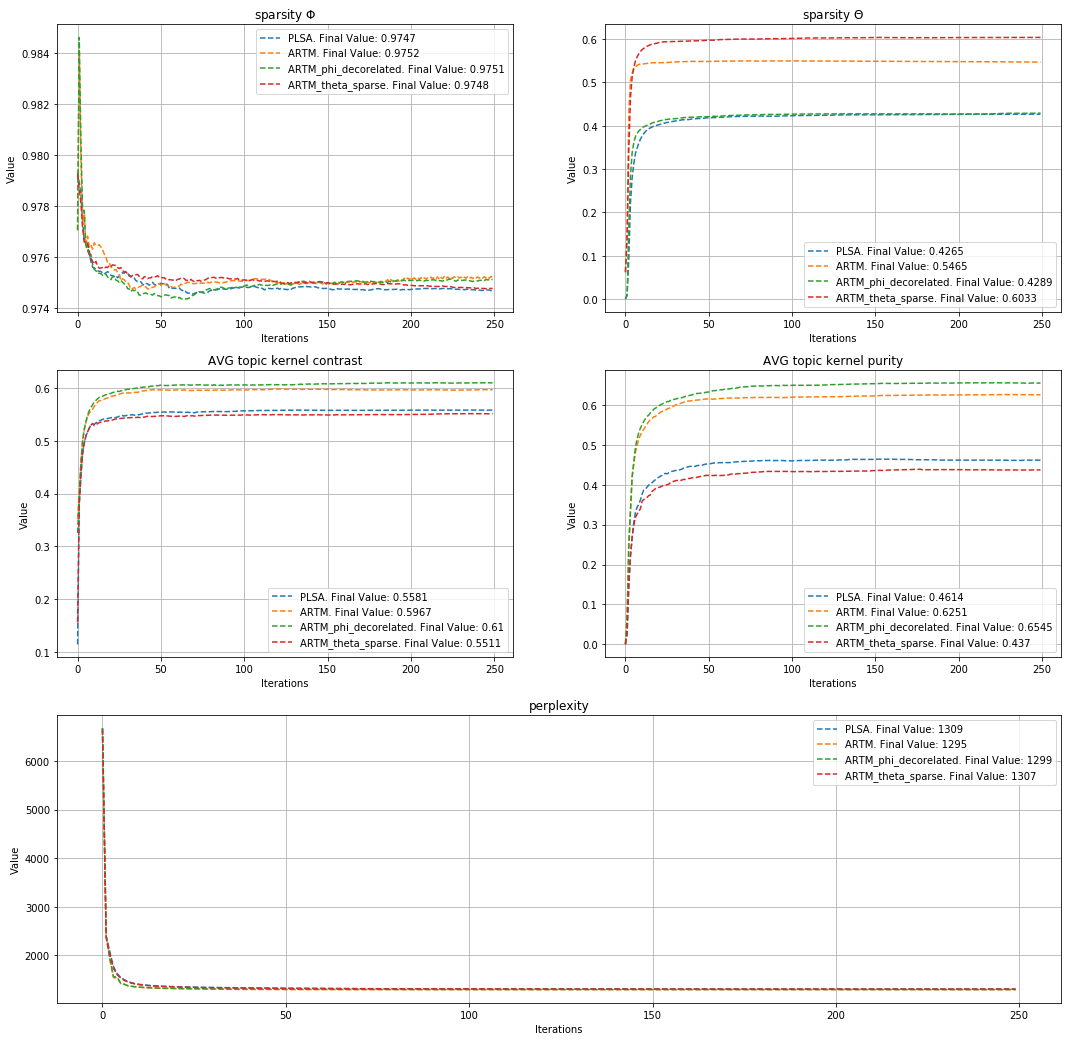

In [13]:
plot_scores(scores_functions,models)

По метрикам качества: 
Регуляризация для разреженности матриц помогла только матрице $\Phi$, для матрицы $\Theta$ оптимум по разреженности для обеих моделей лежит довольно близко. По перплексии модели оказались близки, но PLSA оказалась лучше.

Topics top tokens for PLSA model:
    topic_0: <rights>, <law>, <marriage>, <president>, <bush>, <issue>, <political>,
             <gay>, <vote>, <states>, <american>, <people>, <court>, <amendment>,
             <reagan>, <women>, <years>, <conservative>, <support>, <state>, <white>,
             <civil>, <family>, <social>, <republican>, <human>, <republicans>, <issues>
    topic_1: <iraq>, <war>, <military>, <iraqi>, <troops>, <american>, <soldiers>,
             <forces>, <killed>, <baghdad>, <iraqis>, <people>, <country>, <saddam>,
             <abu>, <army>, <government>, <americans>, <officials>, <ghraib>, <general>,
             <fallujah>, <coalition>, <attacks>, <news>, <pentagon>, <dead>, <occupation>
    topic_2: <november>, <poll>, <house>, <polls>, <electoral>, <governor>, <account>,
             <republicans>, <senate>, <ground>, <turnout>, <trouble>, <parecommend>, <duderino>,
             <contact>, <exit>, <bush>, <vote>, <primary>, <democratic>, <general>,
         

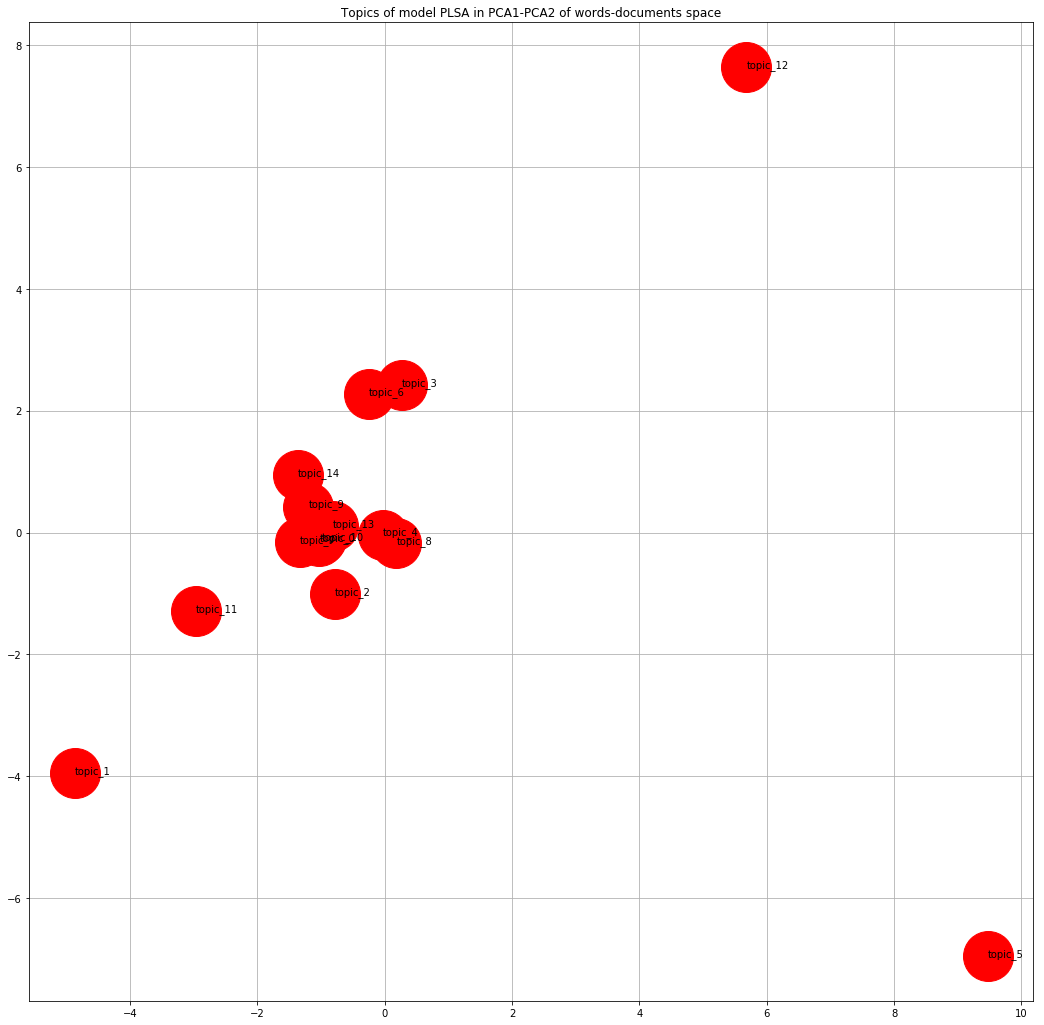

In [14]:
print_top_words("PLSA", model_plsa)    
plot_topics("PLSA",model_plsa)    

Topics top tokens for ARTM model:
    topic_0: <law>, <tax>, <rights>, <court>, <marriage>, <gay>, <reagan>,
             <amendment>, <federal>, <social>, <taxes>, <women>, <supreme>, <civil>,
             <human>, <abortion>, <ban>, <conservative>, <family>, <conservatives>, <legal>,
             <black>, <constitution>, <religious>, <constitutional>, <catholic>, <income>, <reagans>
    topic_1: <military>, <iraqi>, <troops>, <soldiers>, <forces>, <killed>, <baghdad>,
             <iraqis>, <army>, <abu>, <saddam>, <pentagon>, <ghraib>, <fallujah>,
             <rumsfeld>, <coalition>, <occupation>, <dead>, <government>, <afghanistan>, <men>,
             <insurgents>, <prisoners>, <americans>, <officials>, <police>, <violence>, <torture>
    topic_2: <governor>, <electoral>, <account>, <economy>, <labor>, <contact>, <ticket>,
             <challenge>, <sunzoo>, <experience>, <scoop>, <straight>, <challengers>, <voter>,
             <kossacks>, <needed>, <steal>, <recommended>, <sect

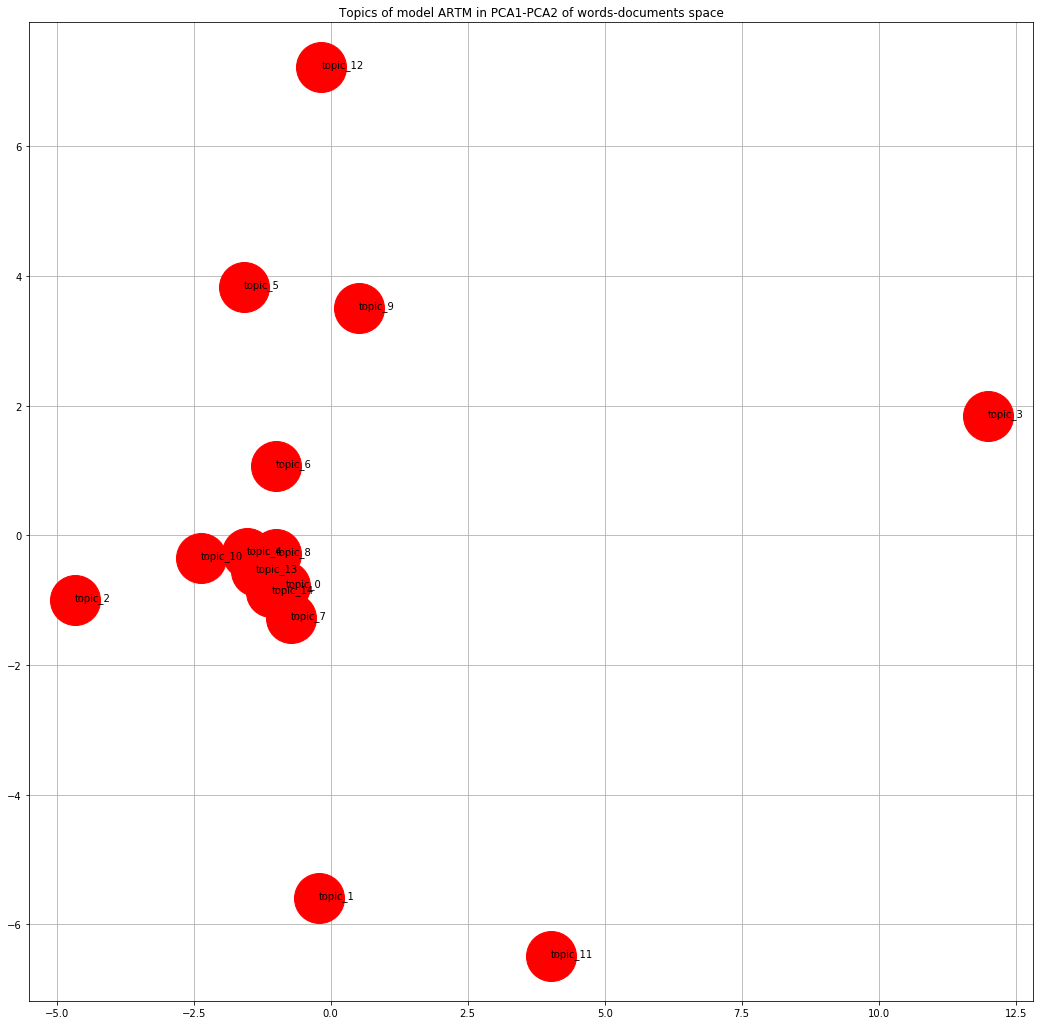

In [15]:
print_top_words("ARTM", model_artm)    
plot_topics("ARTM",model_artm)    